In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import seaborn as sns

sns.set_theme(context='talk', 
              style='whitegrid', 
              palette='Set1',
              font_scale=1.4, 
              rc={'figure.figsize': (14, 6)})

import plotly.graph_objects as go
import plotly.io as pio
import plotly.express as px
import plotly
pio.templates.default = 'plotly_white+presentation'



import scipy.constants as sc

hbarc = sc.hbar*sc.speed_of_light/sc.mega/sc.electron_volt / sc.femto

import json
import os
import sys
sys.path.append('../src')

from luscher_lib import Luscher_zeta, Kcot_luscher

from tqdm import tqdm

In [3]:
import scipy.optimize
from scipy.sparse.linalg import LinearOperator

# sample data

In [4]:
lat_unit = 0.121 # fm
a_inv = hbarc/lat_unit
m_B = 1.072 # in lattice unit
m_pi = 836.5/a_inv

In [5]:
pot = np.loadtxt('../data/su3/fl_1__vc_t+010.txt')

In [6]:
import warnings
warnings.simplefilter('ignore')

In [7]:
ffit = lambda p, x: p[0] * np.exp(-p[1]*x**2) + p[2] * np.exp(-p[3]*x**2)
errf = lambda p, y, x, err: (ffit(p,x)-y)/err
pfit = scipy.optimize.leastsq(errf, [-1, 0.5, -1, 1], args=(pot[:,1], pot[:,0], pot[:,2]), full_output=True)

print('fit params: ', pfit[0])
param_fit = pfit[0]
V_fit = lambda x: param_fit[0] * np.exp(-param_fit[1]*x**2) + param_fit[2] * np.exp(-param_fit[3]*x**2)

fit params:  [-0.18899732  0.03791465 -0.46893186  1.00724437]


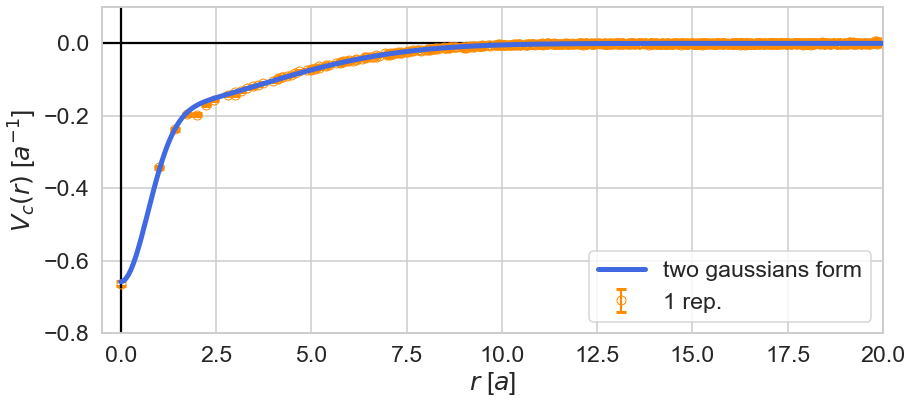

In [8]:
fig, ax = plt.subplots()
ax.errorbar(pot[:,0], pot[:,1], pot[:,2], color='darkorange', fmt='o', mfc='None',
           capsize=5, capthick=3, label='1 rep.')

xls = np.linspace(0, 20, 300)

ax.plot(xls, V_fit(xls), color='royalblue', zorder=3, lw=5,
       label='two gaussians form')

ax.legend()
ax.axhline(0, color='black')
ax.axvline(0, color='black')

ax.set(xlim=(-0.5, 20), ylim=(-0.8, 0.1), xlabel=r'$r$ [$a$]', ylabel=r'$V_c(r)$ [$a^{-1}$]');

build mockup potential for a coarse lattice spacing

In [9]:
V_fit_scaled = lambda x, s: s*param_fit[0] * np.exp(-param_fit[1]*(s*x)**2) + s*param_fit[2] * np.exp(-param_fit[3]*(s*x)**2)

In [10]:
color_list_ = ['dimgray', 'firebrick', 'darkorange', 'mediumturquoise', 'ghostwhite']

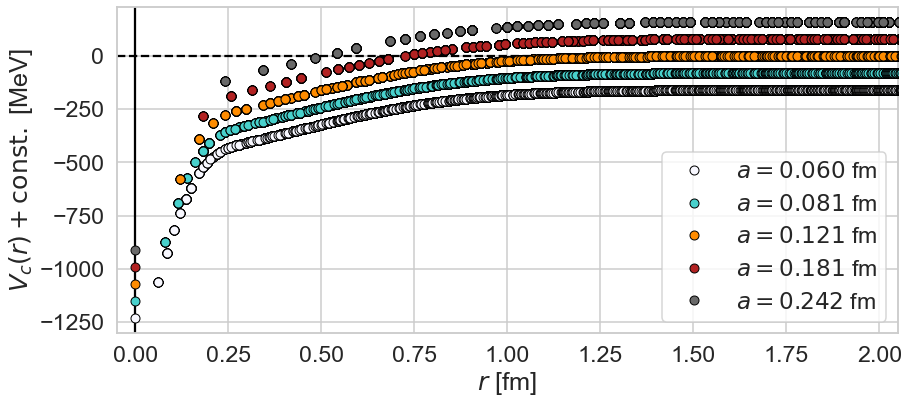

In [11]:
fig, ax = plt.subplots()

Ns = 36
for i, s in enumerate([2, 3/2, 1, 2/3, 1/2][::-1]):

    Ns2 = int(Ns/2/s)
    r_lens = np.array([np.sqrt(x**2 + y**2 + z**2) + 1.0e-5 for z in np.arange(-Ns2,Ns2)
            for y in np.arange(-Ns2, Ns2) for x in np.arange(-Ns2,Ns2)])
    ax.plot(r_lens * lat_unit * s, V_fit_scaled(r_lens, s) * (a_inv/s) + 80 * (i-2), marker='o', mec='black', 
            ls='', color=color_list_[::-1][i], label=fr'$a = {lat_unit*s:.3f}$ fm', zorder=3)
    
ax.legend()

ax.axhline(0, ls='--', color='black')
ax.axvline(0, color='black')
ax.set(xlabel=r'$r$ [fm]', ylabel='$V_c(r) + \mathrm{const.}$ [MeV]', xlim=(-0.05, 2.05))
    
fig.savefig('../figs/hal_pot_finite_volume/mockup_potentials_in_various_lattice_spacing.png', bbox_inches='tight')

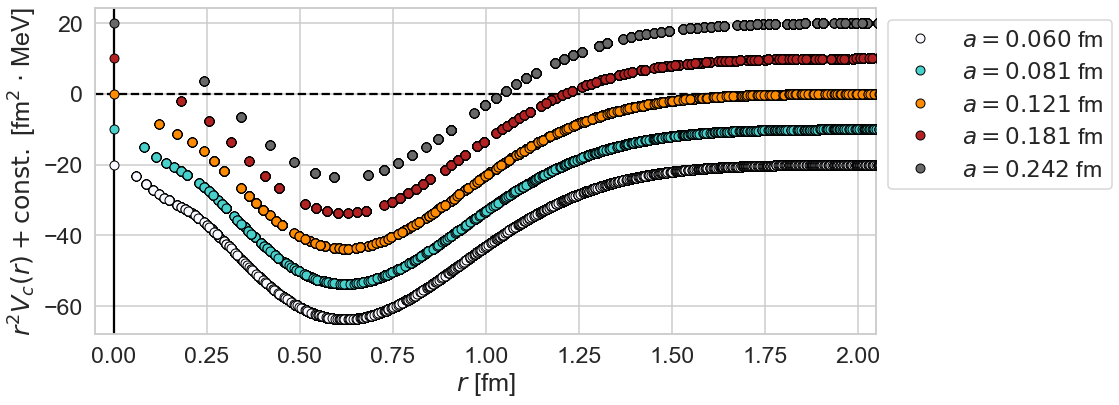

In [12]:
fig, ax = plt.subplots()

Ns = 36
for i, s in enumerate([2, 3/2, 1, 2/3, 1/2][::-1]):

    Ns2 = int(Ns/2/s)
    r_lens = np.array([np.sqrt(x**2 + y**2 + z**2) + 1.0e-5 for z in np.arange(-Ns2,Ns2)
            for y in np.arange(-Ns2, Ns2) for x in np.arange(-Ns2,Ns2)])
    ax.plot(r_lens * lat_unit * s, (r_lens * lat_unit * s)**2 * V_fit_scaled(r_lens, s) * (a_inv/s) + 10 * (i-2), marker='o', mec='black', 
            ls='', color=color_list_[::-1][i], label=fr'$a = {lat_unit*s:.3f}$ fm', zorder=3)

    
ax.legend(loc='upper left', bbox_to_anchor=(1,1))

ax.axhline(0, ls='--', color='black')
ax.axvline(0, color='black')
ax.set(xlabel=r'$r$ [fm]', ylabel='$r^2V_c(r) + \mathrm{const.}$ [fm$^2$ $\cdot$ MeV]', xlim=(-0.05, 2.05))
    
fig.savefig('../figs/hal_pot_finite_volume/mockup_potentials_r2_in_various_lattice_spacing.png', bbox_inches='tight')

# calc eigen values

In [13]:
def A1_projection(wave_in):
    Ns = round(len(wave_in)**(1/3))
    wave = wave_in.reshape(Ns,Ns,Ns)
    wave_tmp1 = (wave[:,:,:] + np.roll(wave,-1,0)[::-1,:,:]
                + np.roll(wave,-1,1)[:,::-1,:]
                + np.roll(wave,-1,2)[:,:,::-1]
                + np.roll(np.roll(wave,-1,0),-1,1)[::-1,::-1,:]
                + np.roll(np.roll(wave,-1,1),-1,2)[:,::-1,::-1]
                + np.roll(np.roll(wave,-1,2),-1,0)[::-1,:,::-1]
                + np.roll(np.roll(np.roll(wave,-1,0),-1,1),-1,2)[::-1,::-1,::-1])/8.0
    wave_tmp2 = (wave_tmp1 
                + np.swapaxes(wave_tmp1,0,1)
                + np.swapaxes(wave_tmp1,1,2)
                + np.swapaxes(wave_tmp1,2,0)
                + np.swapaxes(np.swapaxes(wave_tmp1,0,1),1,2)
                + np.swapaxes(np.swapaxes(wave_tmp1,0,2),2,1))/6.0e0

    return wave_tmp2.flatten()

def make_pot_data(Ns):
    Ns2 = Ns//2
    
    r_lens = np.array([np.sqrt(x**2 + y**2 + z**2) + 1.0e-5 for z in np.arange(-Ns2,Ns2)
            for y in np.arange(-Ns2, Ns2) for x in np.arange(-Ns2,Ns2)])

    
    return V_fit(r_lens), r_lens

In [14]:
class FV_spectra(object):
    def __init__(self, pot_func, red_mass):
        self.pot_func = pot_func
        self.red_mass = red_mass
    
    def make_pot_data(self, Ns):
        Ns2 = Ns//2
    
        self.r_lins = np.array([np.sqrt(x**2 + y**2 + z**2) + 1.0e-5 for z in np.arange(-Ns2,Ns2)
            for y in np.arange(-Ns2, Ns2) for x in np.arange(-Ns2,Ns2)])
        
        self.pot = self.pot_func(self.r_lins)
        
        return self.pot, self.r_lins
        

    def calc_eigen(self, Ns=48, Nev=10):
        print(f'calc. Ns = {Ns}, Nev = {Nev}')
        pot, _ = self.make_pot_data(Ns)
        
        lap = lambda vec: - 6.0*vec + ( np.roll(vec,+1,0) + np.roll(vec,-1,0) 
                              + np.roll(vec,+1,1) + np.roll(vec,-1,1) 
                              + np.roll(vec,+1,2) + np.roll(vec,-1,2) )

        Vol = Ns**3
        Umat = LinearOperator((Vol,Vol), 
                matvec = lambda vec: (pot * vec 
                  - lap(vec.reshape(Ns,Ns,Ns)).flatten()/(2.0*self.red_mass)), 
                dtype='float64')

        self.vals, self.vecs = scipy.sparse.linalg.eigsh(Umat, which='SA', k = Nev)
        
        a1norms = []
        for nth in range(Nev):
            a1 = A1_projection(self.vecs[:,nth])
            a1norms.append(np.sum(a1**2))
            print(f'{nth}: {self.vals[nth]:.3f} {np.sum(a1**2):.2f}')
        self.a1norms = np.array(a1norms)
        return self.vals, self.vecs, self.a1norms

In [15]:
class LD(object):
    def __init__(self, L, level, m_B, m_pi, dE):
        self.L = L
        self.level = level
        self.m_pi = m_pi
        self.m_B = m_B
        
        self.kcs = Kcot_luscher(self.L, self.m_B, self.m_B)
        
        self.k2 = dE * m_B
        
        self.k2mpi2 = self.k2/self.m_pi**2
        self.kcot_mpi = self.kcs.kcot(self.k2) / self.m_pi
        
    def generate_reference_line(self, xlim, ylim, dk2=0.01, point_max=2000, delta_y_limit=0.5):
        self.xlim = xlim
        self.ylim = ylim
        def _gen_reference_line(x0, y0, dk2):
            _k2mpi2_ref = [x0]
            _kcot_mpi_ref = [y0]
            for i in range(point_max):
                x1 = x0 + dk2
                y1 = self.kcs.kcot(x1 * self.m_pi**2)/self.m_pi
                
                if np.abs(y1 - y0) > delta_y_limit:
                    dk2 /= 2
                    continue
                    
                _k2mpi2_ref.append(x1)
                _kcot_mpi_ref.append(y1)
                                
                if (y1 >= ylim[1]) or (y1 <= ylim[0]):
                    break
                if (x1 >= xlim[1]) or (x1 <= xlim[0]):
                    break

                x0, y0 = x1, y1
            return _k2mpi2_ref, _kcot_mpi_ref

        _k2mpi2_ref_1, _kcot_mpi_ref_1 = _gen_reference_line(self.k2mpi2, self.kcot_mpi, dk2)
        _k2mpi2_ref_2, _kcot_mpi_ref_2 = _gen_reference_line(self.k2mpi2, self.kcot_mpi, - dk2)
        
        self.k2mpi2_ref = np.concatenate([_k2mpi2_ref_2[1:][::-1], _k2mpi2_ref_1])
        self.kcot_mpi_ref = np.concatenate([_kcot_mpi_ref_2[1:][::-1], _kcot_mpi_ref_1])

In [16]:
def calc_kcot_vs_k2(L, level, m_B, m_pi, dE, xlim, ylim):
    ld = LD(L, level, m_B, m_pi, dE)
    ld.generate_reference_line(xlim, ylim, dk2=0.001, delta_y_limit=0.1)
    
    fig, ax = plt.subplots()
    ax.plot(ld.k2mpi2, ld.kcot_mpi, 'o', ms=25, color='C1', zorder=3,
           label=f'$L = {L}$')
    ax.plot(ld.k2mpi2_ref, ld.kcot_mpi_ref, '--',color='grey')


    if xlim[0] < 0:
        xbs = np.concatenate([np.linspace(xlim[0], -1e-1), np.linspace(-1e-1, -1e-4)])
        ax.plot(xbs, - np.sqrt(-xbs), color='black', ls='-')

    ax.legend()
    ax.axhline(0, color='black')
    ax.axvline(0, color='black')
    ax.set(xlabel=r'$(k/m_\pi)^2$', ylabel=r'$k\cot\delta/m_\pi$', xlim=xlim, ylim=ylim)
    
    return ld

In [17]:
ld_dic = {}

In [18]:
fv_dic = {}
for s in ['2', '3/2', '1', '2/3', '1/2']:
    fv_dic[s] = FV_spectra(lambda x: V_fit_scaled(x, eval(s)), 0.5 * m_B * eval(s))

In [19]:
xlim0 = (-0.2, 0.15)
ylim0 = (-0.5, 0.1)

24 -> 12
calc. Ns = 12, Nev = 2
0: -0.076 1.00
1: 0.033 1.00
24 -> 16
calc. Ns = 16, Nev = 2
0: -0.045 1.00
1: 0.033 1.00
24 -> 24
calc. Ns = 24, Nev = 2
0: -0.028 1.00
1: 0.023 1.00
24 -> 36
calc. Ns = 36, Nev = 2
0: -0.019 1.00
1: 0.016 1.00
24 -> 48
calc. Ns = 48, Nev = 2
0: -0.014 1.00
1: 0.012 1.00


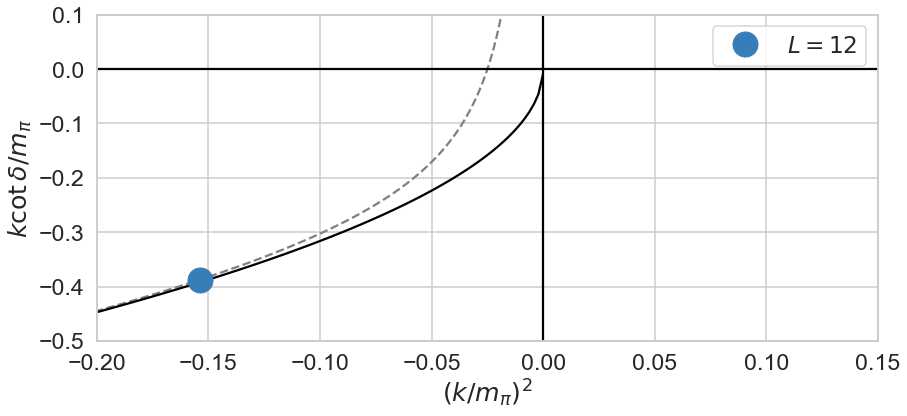

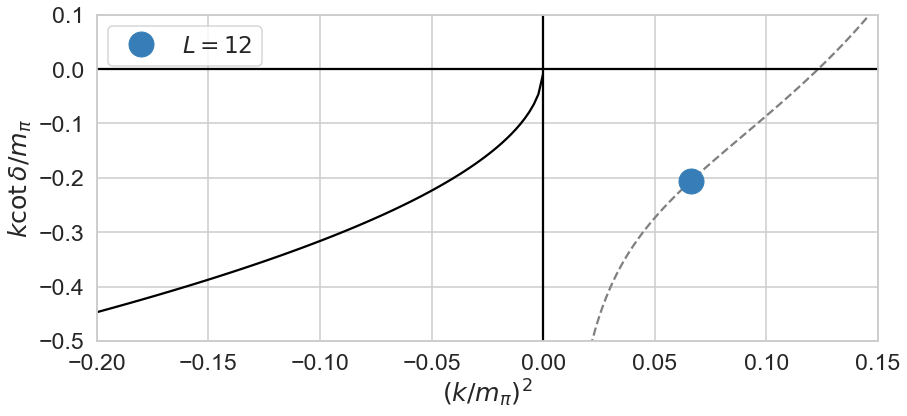

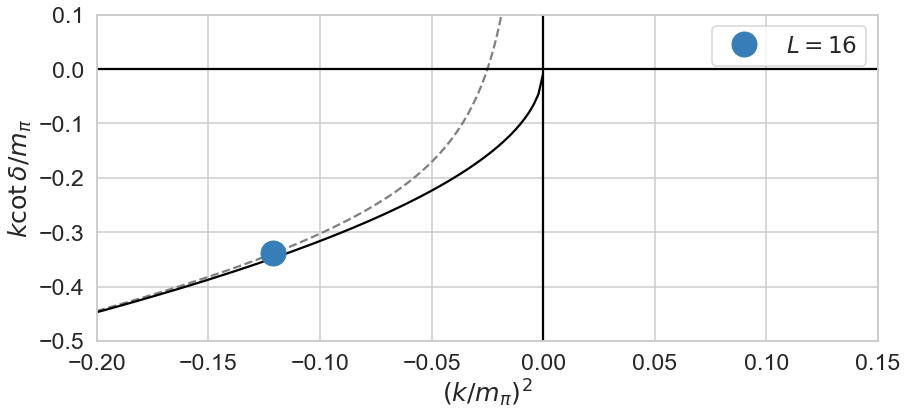

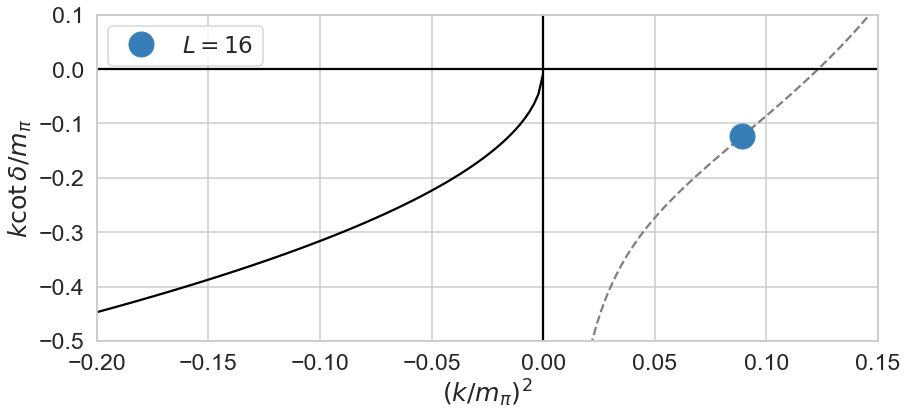

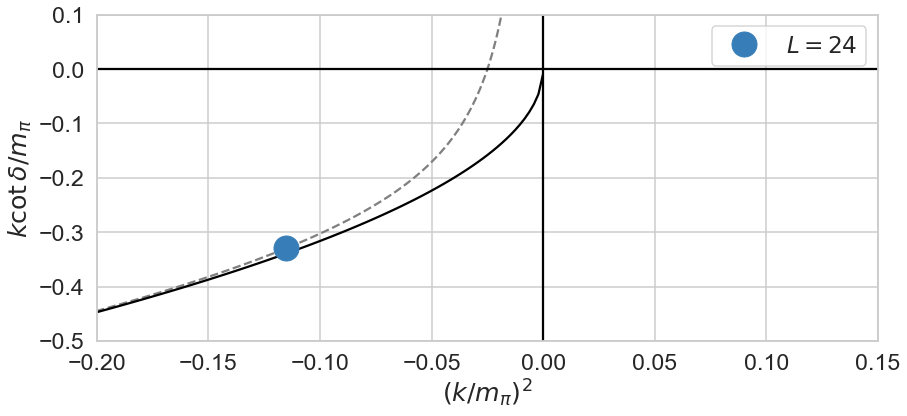

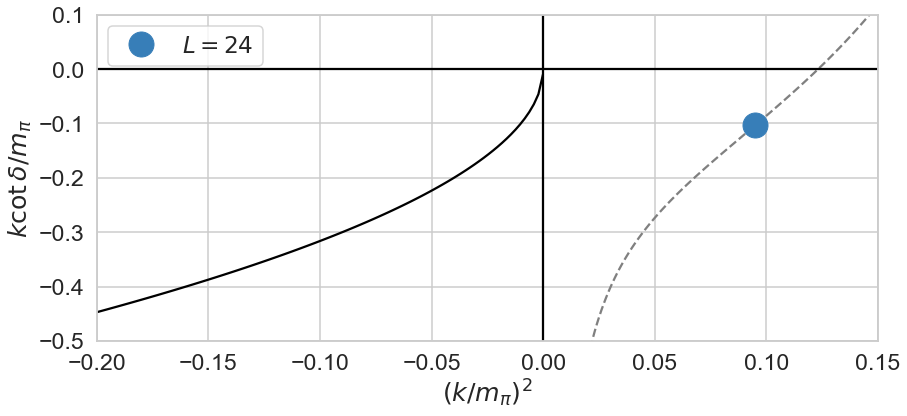

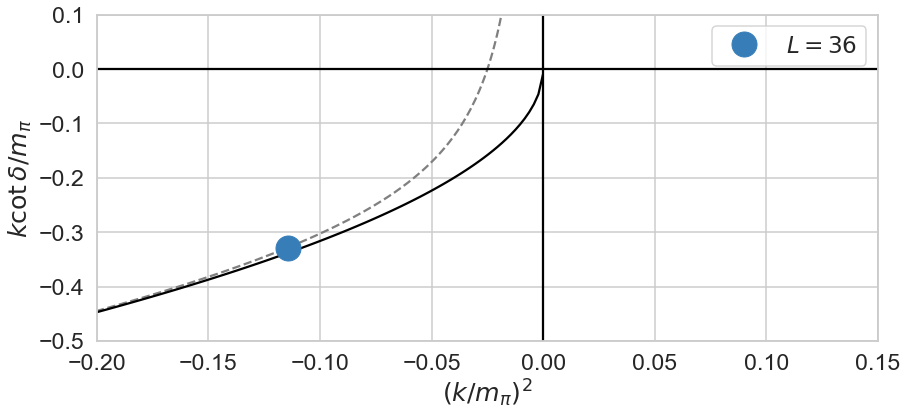

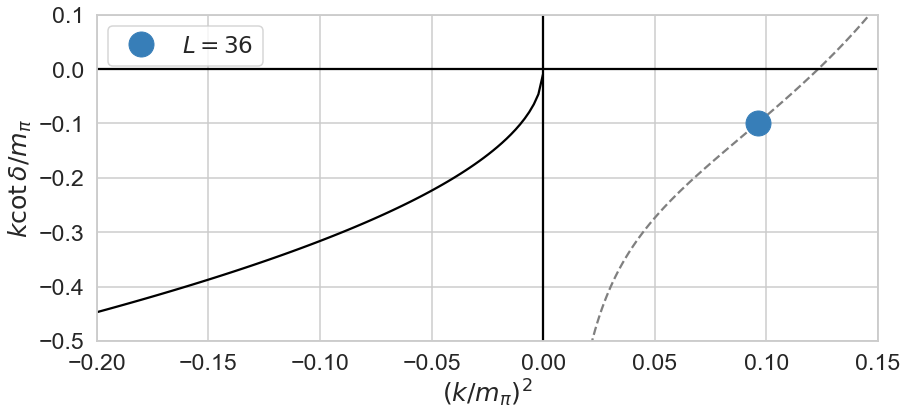

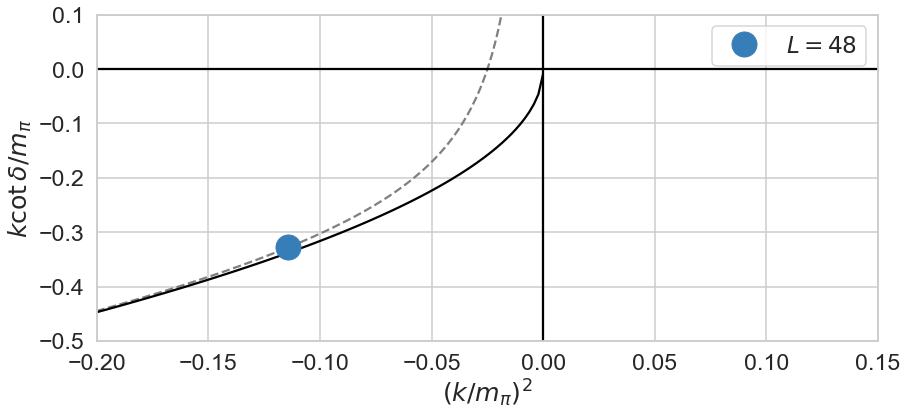

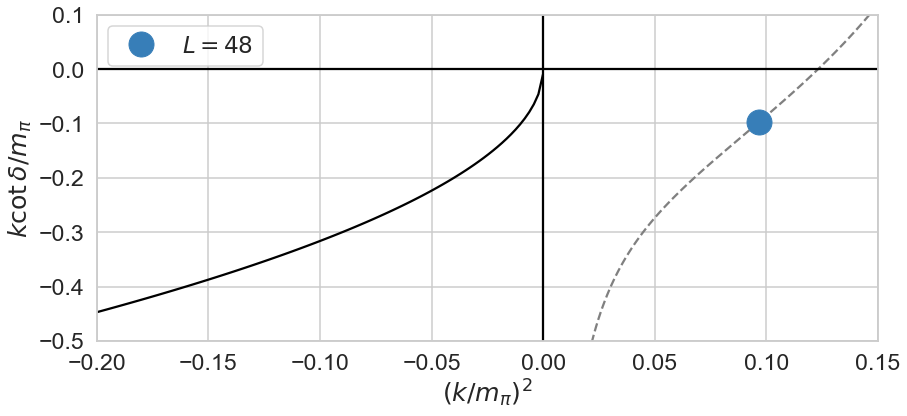

In [20]:
L = 24

for s in ['2', '3/2', '1', '2/3', '1/2']:
    Ns = int(L / eval(s))
    print(f'{L} -> {Ns}')
    vals, _, a1norms = fv_dic[s].calc_eigen(Ns=Ns, Nev=2)
    ld_dic[(Ns,0,s)] = calc_kcot_vs_k2(Ns, 0, m_B * eval(s), m_pi * eval(s), vals[0], xlim0, ylim0)
    ld_dic[(Ns,1,s)] = calc_kcot_vs_k2(Ns, 1, m_B * eval(s), m_pi * eval(s), vals[1], xlim0, ylim0)

36 -> 18
calc. Ns = 18, Nev = 2
0: -0.070 1.00
1: 0.008 1.00
36 -> 24
calc. Ns = 24, Nev = 2
0: -0.038 1.00
1: 0.008 1.00
36 -> 36
calc. Ns = 36, Nev = 2
0: -0.024 1.00
1: 0.006 1.00
36 -> 54
calc. Ns = 54, Nev = 2
0: -0.016 1.00
1: 0.004 1.00
36 -> 72
calc. Ns = 72, Nev = 2
0: -0.012 1.00
1: 0.003 1.00


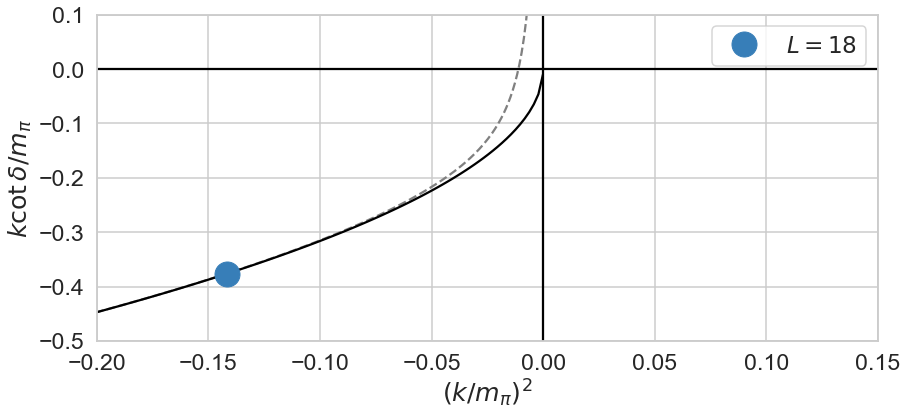

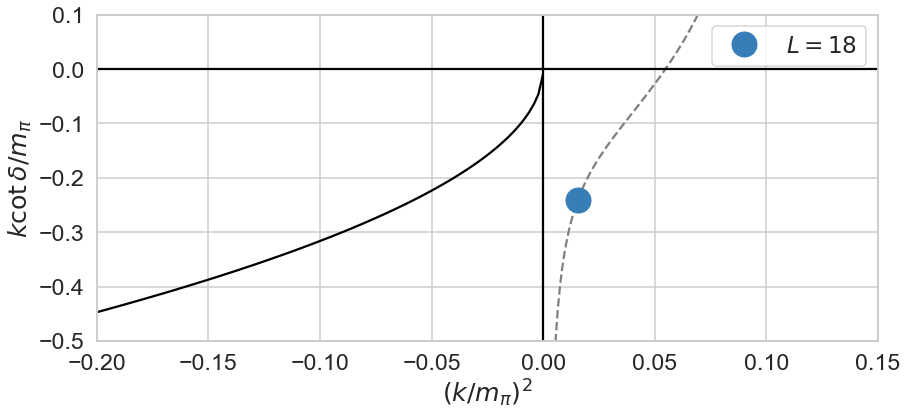

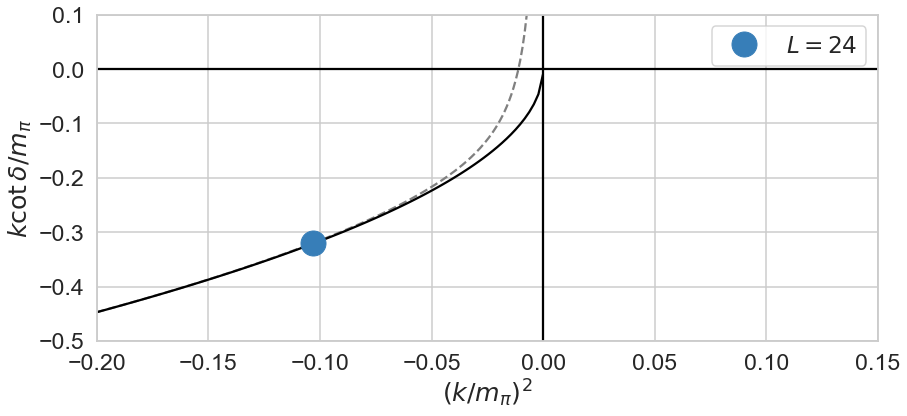

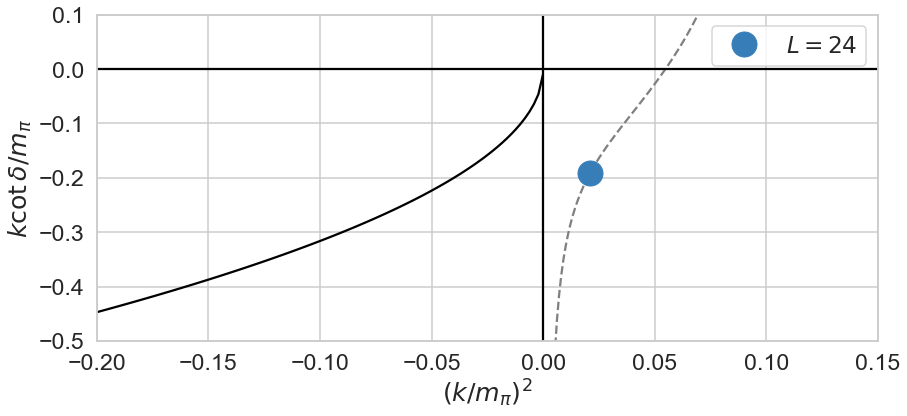

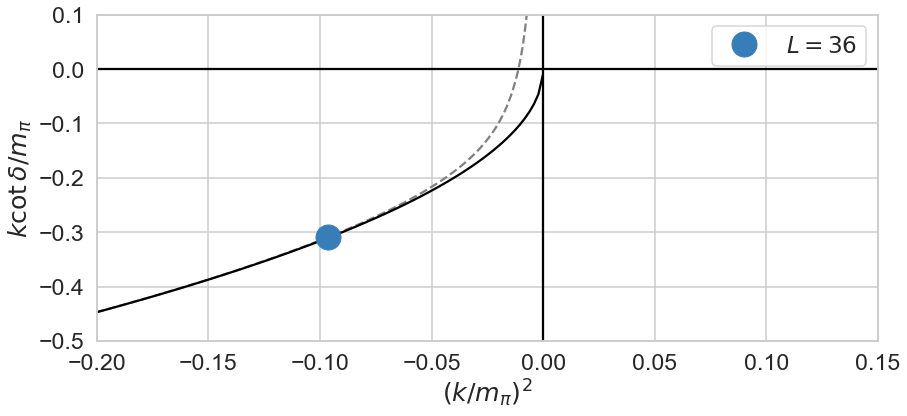

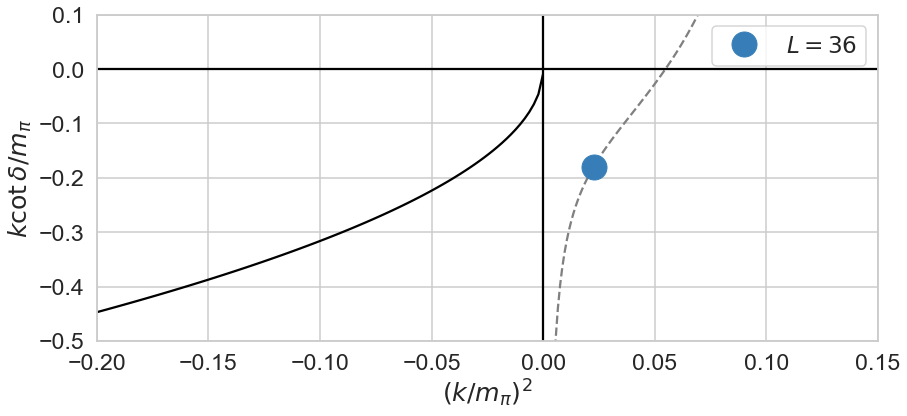

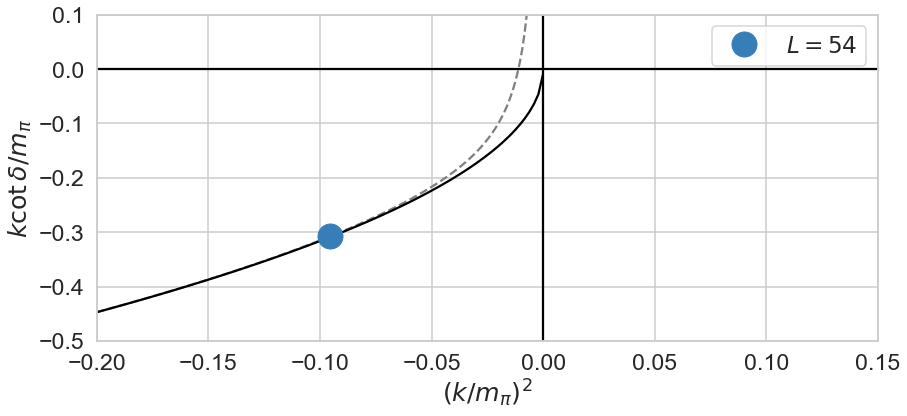

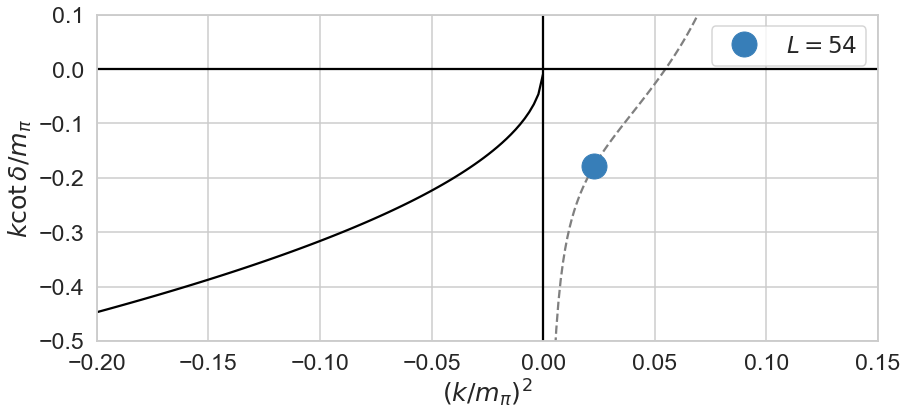

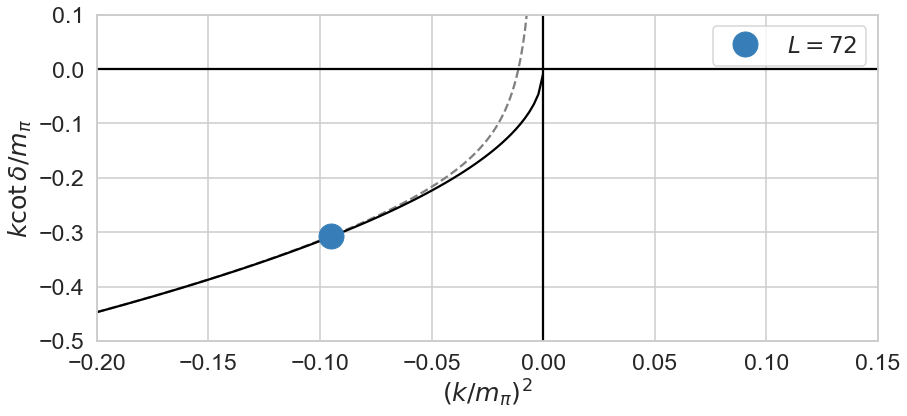

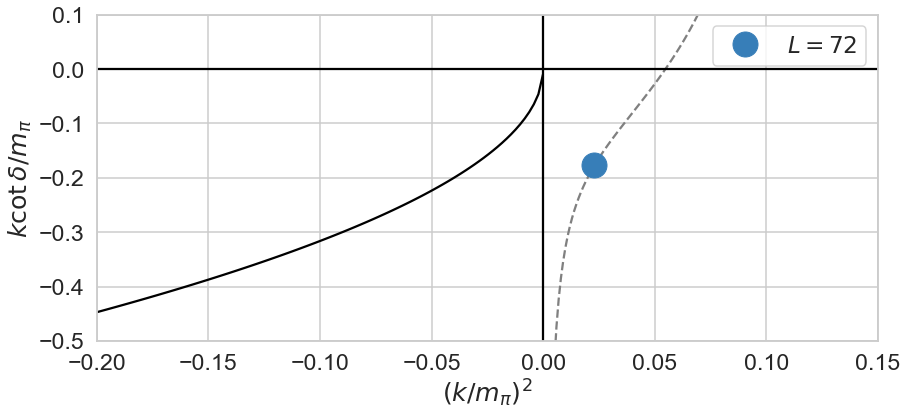

In [21]:
L = 36

for s in ['2', '3/2', '1', '2/3', '1/2']:
    Ns = int(L / eval(s))
    print(f'{L} -> {Ns}')
    vals, _, a1norms = fv_dic[s].calc_eigen(Ns=Ns, Nev=2)
    ld_dic[(Ns,0,s)] = calc_kcot_vs_k2(Ns, 0, m_B * eval(s), m_pi * eval(s), vals[0], xlim0, ylim0)
    ld_dic[(Ns,1,s)] = calc_kcot_vs_k2(Ns, 1, m_B * eval(s), m_pi * eval(s), vals[1], xlim0, ylim0)

48 -> 24
calc. Ns = 24, Nev = 2
0: -0.069 1.00
1: 0.003 1.00
48 -> 32
calc. Ns = 32, Nev = 2
0: -0.037 1.00
1: 0.003 1.00
48 -> 48
calc. Ns = 48, Nev = 2
0: -0.023 1.00
1: 0.002 1.00
48 -> 72
calc. Ns = 72, Nev = 2
0: -0.015 1.00
1: 0.001 1.00
48 -> 96
calc. Ns = 96, Nev = 2
0: -0.011 1.00
1: 0.001 1.00


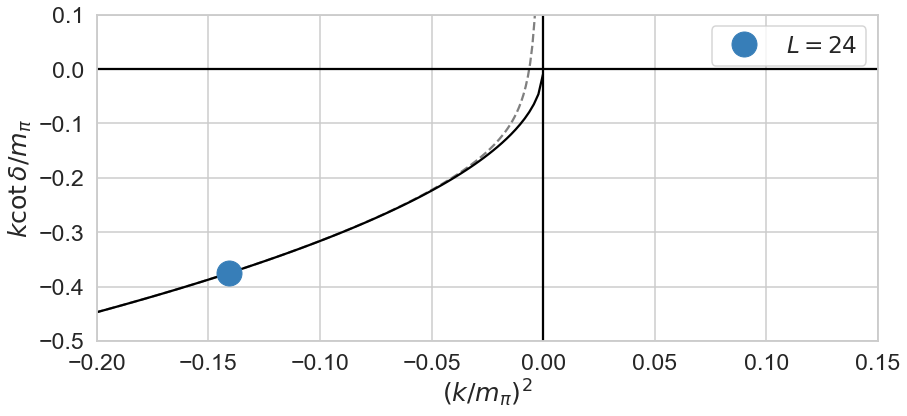

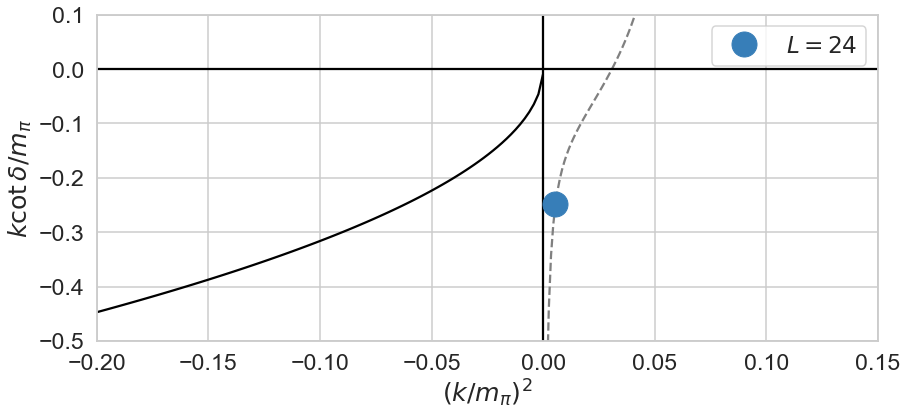

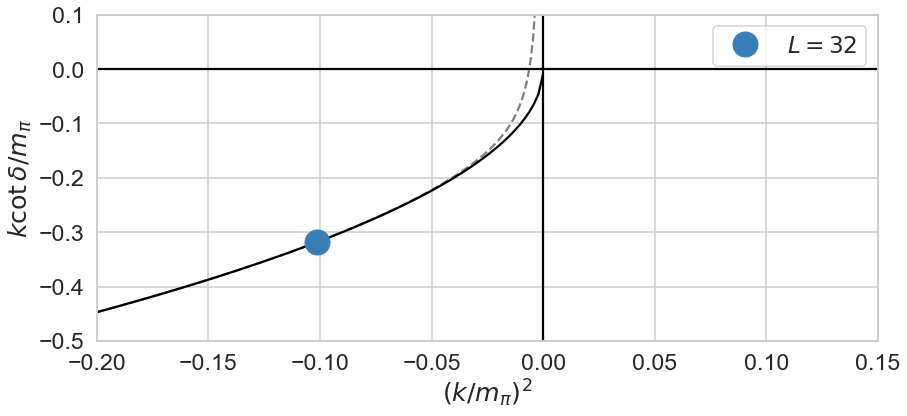

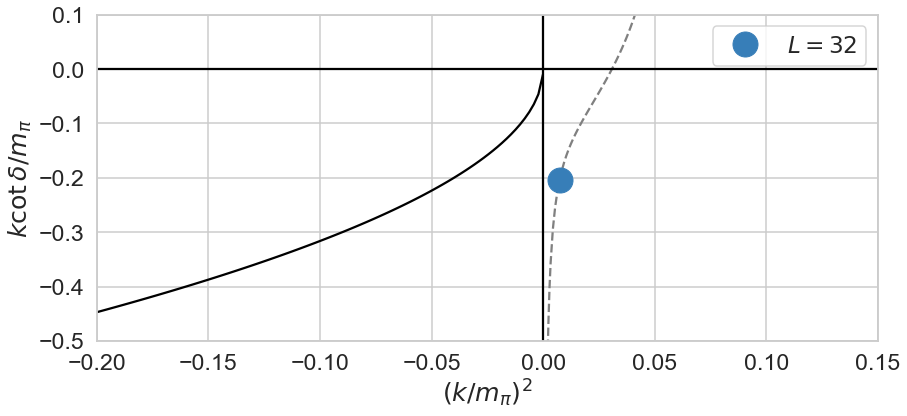

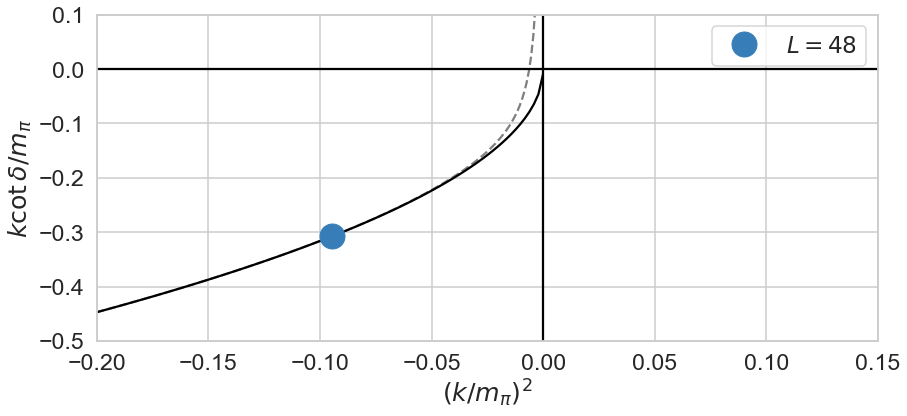

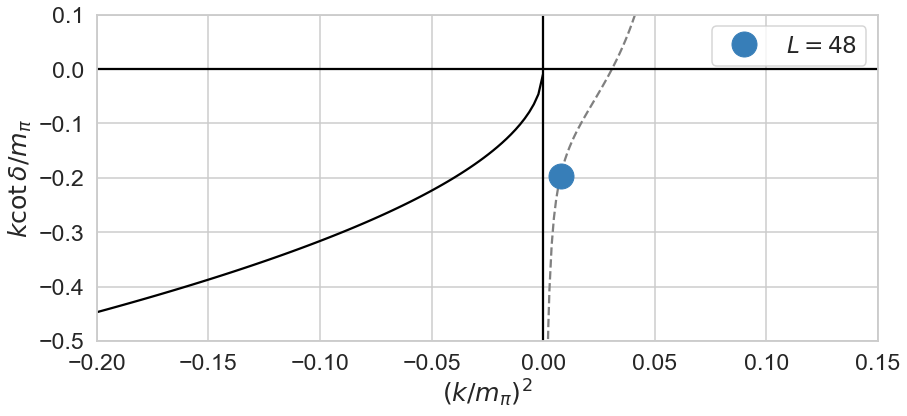

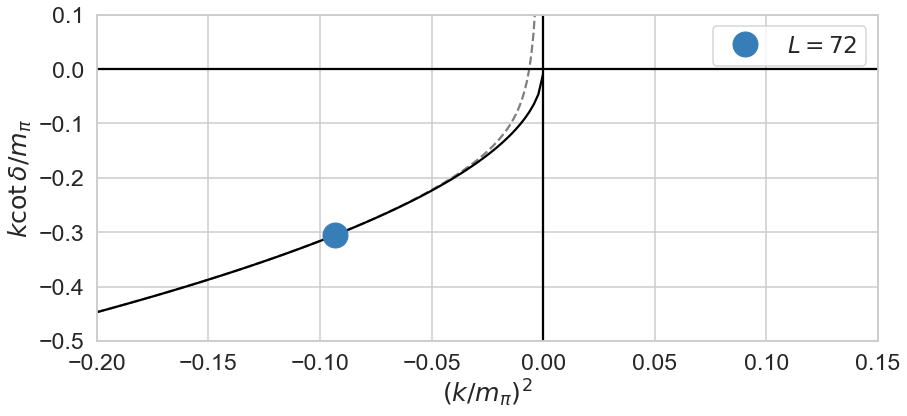

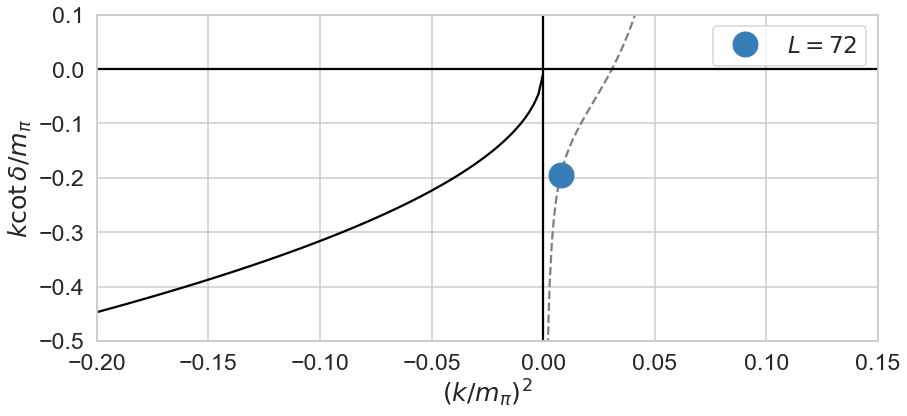

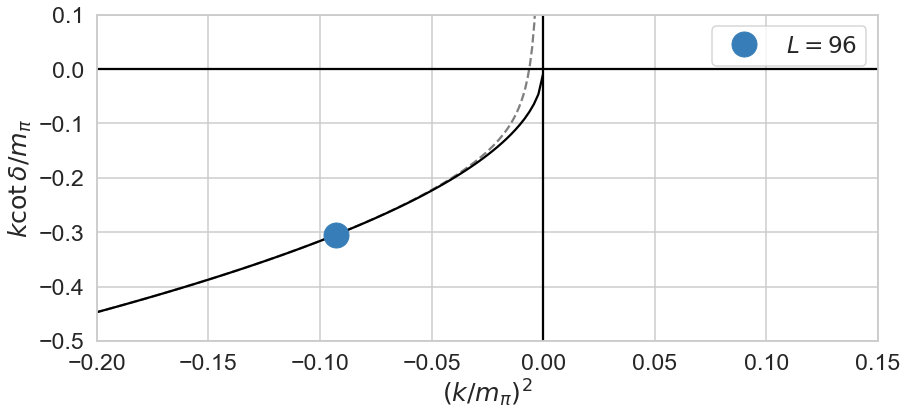

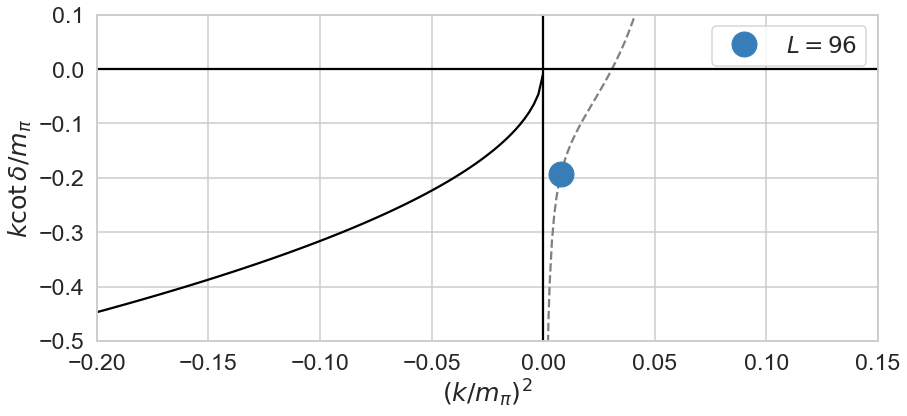

In [22]:
L = 48

for s in ['2', '3/2', '1', '2/3', '1/2']:
    Ns = int(L / eval(s))
    print(f'{L} -> {Ns}')
    vals, _, a1norms = fv_dic[s].calc_eigen(Ns=Ns, Nev=2)
    ld_dic[(Ns,0,s)] = calc_kcot_vs_k2(Ns, 0, m_B * eval(s), m_pi * eval(s), vals[0], xlim0, ylim0)
    ld_dic[(Ns,1,s)] = calc_kcot_vs_k2(Ns, 1, m_B * eval(s), m_pi * eval(s), vals[1], xlim0, ylim0)

In [23]:
color_list = {'2': 'dimgray', '3/2': 'firebrick', '1': 'darkorange', '2/3': 'mediumturquoise', '1/2': 'ghostwhite'}

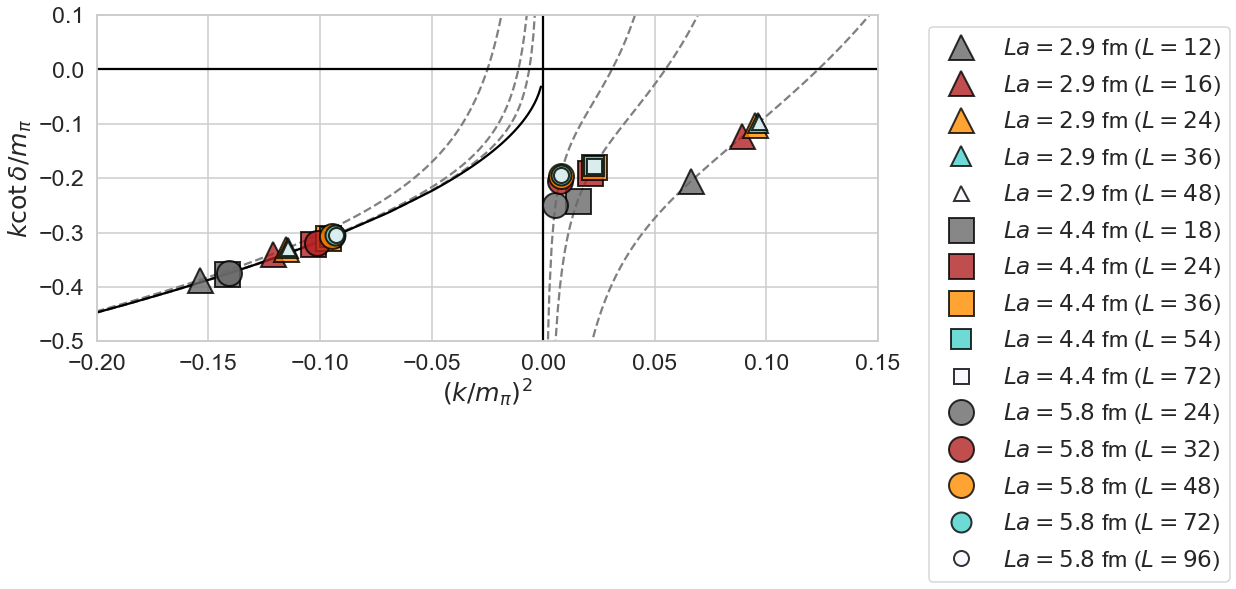

In [24]:
fig, ax = plt.subplots()

k2ls = np.concatenate([np.linspace(-1, -0.05), np.linspace(-0.05,-1e-3)])
ax.plot(k2ls, - np.sqrt(-k2ls), ls='-', color='black')


for key in ld_dic.keys():
    ld = ld_dic.get(key)
    c = color_list.get(key[2])
    _lat = lat_unit * eval(key[2])
    sym = {24: '^', 36: 's', 48: 'o'}[int(key[0]*eval(key[2]))]
    ms = {'2':25, '3/2': 25, '1': 25, '2/3': 20, '1/2': 15}[key[2]]
    if key[1] == 0:
        lbl = fr'$La = {key[0]*_lat:.1f}$ fm ($L = {key[0]}$)'
    else:
        lbl = ''
    ax.plot(ld.k2mpi2, ld.kcot_mpi, color=c, marker=sym, mec='black', mew=2, ls='',
            ms=ms, label=lbl, zorder=3, alpha=0.8)
    if key[2] == '1':
        ax.plot(ld.k2mpi2_ref, ld.kcot_mpi_ref, ls='--', color='grey', zorder=1)
#        ax.plot([np.nan], [np.nan], marker=sym, mec='black', mfc='None', mew=2,
#               ms=25, label=lbl, color='black')
    

ax.axhline(0, color='black')
ax.axvline(0, color='black')
ax.legend(loc='upper left', bbox_to_anchor=(1.05,1))
ax.set(ylim=ylim0, xlim=xlim0, xlabel=r'$(k/m_\pi)^2$', ylabel=r'$k\cot\delta/m_\pi$')

fig.savefig('../figs/hal_pot_finite_volume/kcot_vs_k2_lattice_spacing_dependence.png', bbox_inches='tight')


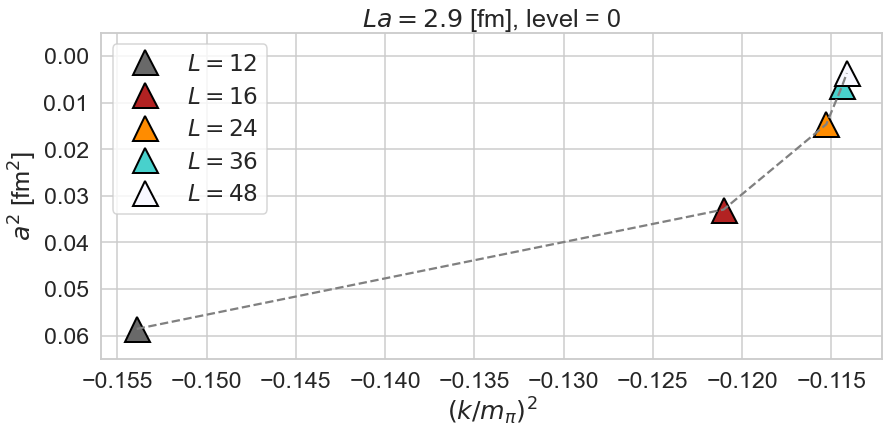

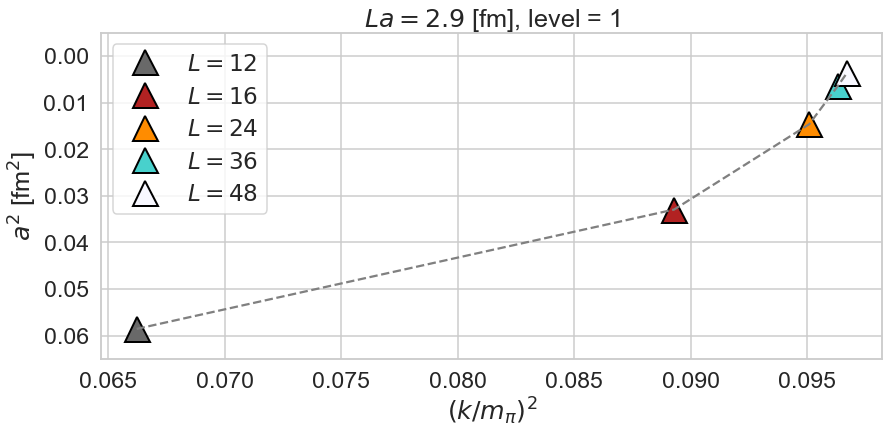

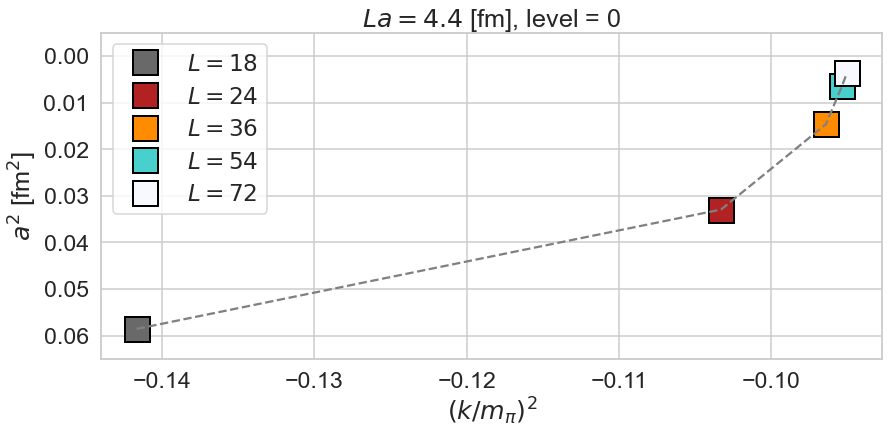

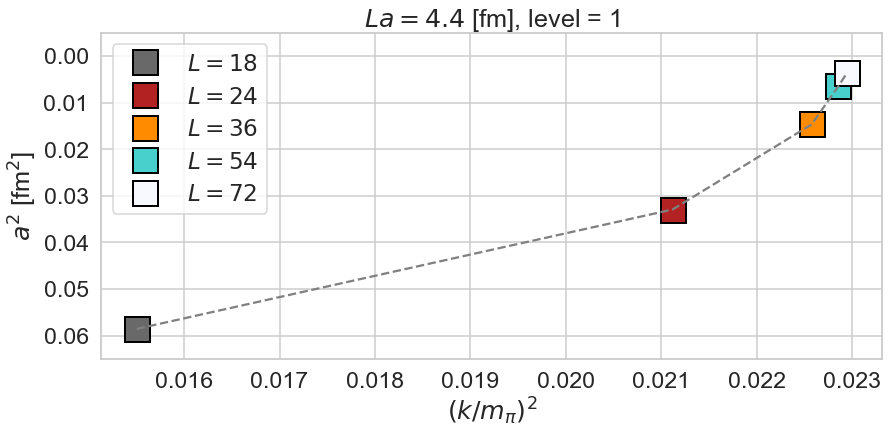

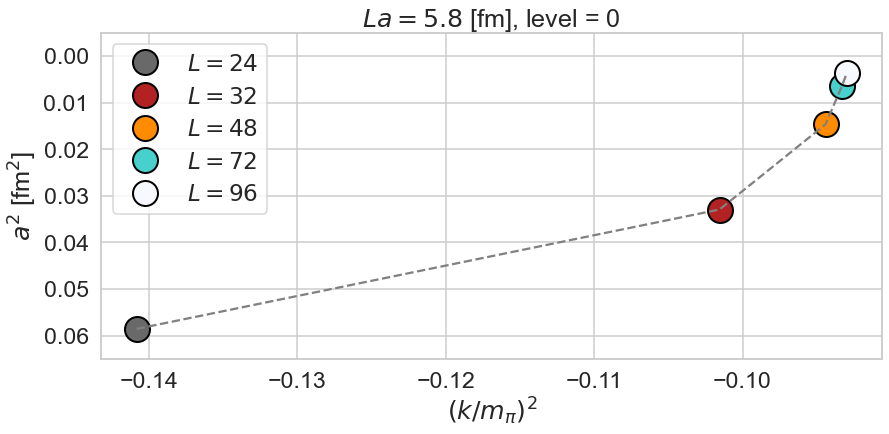

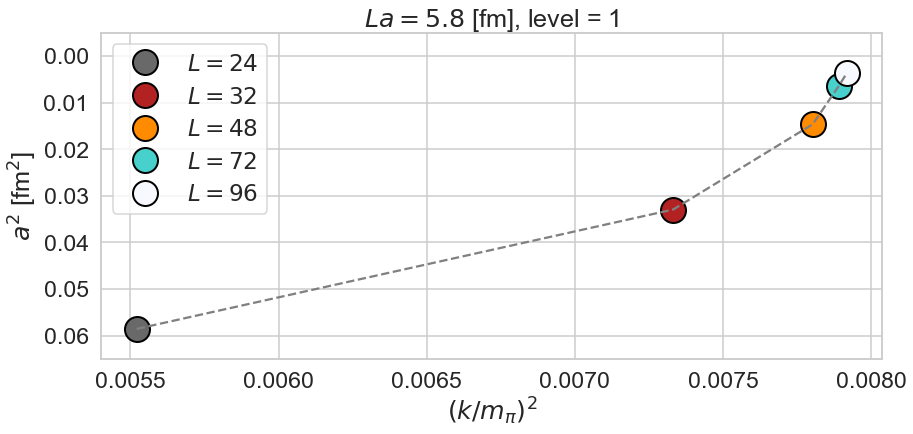

In [26]:
def plot_a2_dep(L0, level):
    fig, ax = plt.subplots()

    xs = []
    ys = []
    for s in ['2','3/2','1','2/3','1/2']:
        ld = ld_dic.get((int(L0/eval(s)), level, s))
        c = color_list.get(s)
        _lat = lat_unit * eval(s)
        sym = {24: '^', 36: 's', 48: 'o'}[L0]

        xs.append(ld.k2mpi2)
        ys.append(_lat**2)

        ax.plot(ld.k2mpi2, _lat**2, marker=sym, color=c, ms=25, mew=2, mec='black', ls='',
               label=fr'$L = {int(L0/eval(s))}$')

    ax.legend(loc='upper left')

    ax.plot(xs, ys, ls='--', color='grey')
    ax.set(ylim=(0.065, -0.005), xlabel=r'$(k/m_\pi)^2$', ylabel=r'$a^2$ [fm$^2$]',
          title=rf'$La = {L0*lat_unit:.1f}$ [fm], level = {level}')
    fig.savefig(f'../figs/hal_pot_finite_volume/k2mpi2_cut_off_dependence_orig_L{L0}_level_{level}.png', bbox_inches='tight')
    
    
for L0 in [24, 36, 48]:
    for level in [0, 1]:
        plot_a2_dep(L0, level)